# FSL motion correction with McFlirt

The FSL motion correction command line utilitiy is called [mcflirt](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT).

Here we will run `mcflirt` on our fixed BOLD time series.  It will do the familiar steps:

* Calculate motion between each volume and the reference volume (by default, the middle volume);
* Reslice the volumes that have moved to match the first volume.

You'll need to run the [diagnostics_again](diagnostics_again.ipynb) notebook first to write out the fixed data.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
# numpy printing defaults
np.set_printoptions(precision=3, suppress=True)
# Set some plot defaults
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

Run `mcflirt` from the command line:

In [3]:
!fsl5.0-mcflirt -in fixed_bold.nii.gz -plots

In [4]:
params = np.loadtxt('fixed_bold_mcf.par')
params

array([[-0.002,  0.   , -0.001, -0.024,  0.054, -0.102],
       [-0.002,  0.001, -0.   ,  0.004,  0.028, -0.114],
       [-0.002,  0.001, -0.   ,  0.009,  0.073, -0.088],
       ..., 
       [-0.001, -0.002,  0.   ,  0.078,  0.035, -0.52 ],
       [-0.001, -0.002, -0.   ,  0.083,  0.026, -0.498],
       [-0.001, -0.002, -0.   ,  0.08 ,  0.04 , -0.502]])

In [5]:
params.shape

(172, 6)

In [6]:
params[172 / 2, :] # Middle volume is reference

array([ 0., -0.,  0.,  0.,  0.,  0.])

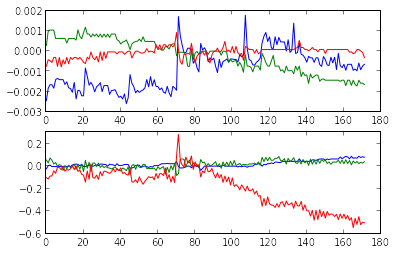

In [7]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(params[:, :3]) # Rotations
axes[1].plot(params[:, 3:]); # Translations

Which principal components remain after correction?

In [8]:
from nipy import load_image, save_image
from nipy.core.api import Image, drop_io_dim, rollimg
from nipy.algorithms.utils.pca import pca_image
from nipy.algorithms.diagnostics import screens

Load the motion-corrected BOLD image:

In [9]:
mcfixed_img = load_image('fixed_bold_mcf.nii.gz')

In [10]:
img_pca_results = pca_image(mcfixed_img, axis='t', ncomp=10)

/usr/local/lib/python2.7/dist-packages/nipy/algorithms/utils/pca.py:143: RuntimeWarning: divide by zero encountered in divide
  return np.where(rmse<=0, 0, 1. / rmse)


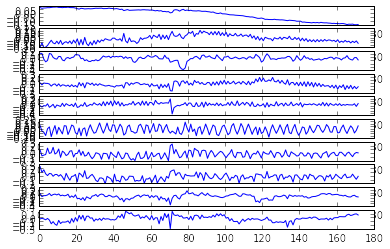

In [11]:
fig, axes = plt.subplots(10, 1)
for i, ax in enumerate(axes):
    ax.plot(img_pca_results['basis_vectors'][:, i])

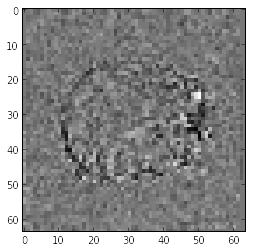

In [12]:
pca0 = img_pca_results['basis_projections']
plt.imshow(pca0.get_data()[:, :, 17, 4])

The PCA hasn't changed very much, and several components, including component 4, look like movement effects.

Fix image for `fslview` again:

In [13]:
import nibabel as nib
data = pca0.get_data()
fixed_pca = nib.Nifti1Image(data, None, mcfixed_img.metadata['header'])
nib.save(fixed_pca, 'mcfixed_pca_projections.nii.gz')